# Goal

Maybe the first industry to heavily rely on data science was the online ads industry. Data Science is used to choose which ads to show, how much to pay, optimize the ad text and the position as well as in countless of other related applications.

Optimizing ads is one of the most intellectually challenging jobs a data scientist can do. It is a really complex problem given the huge (really really huge) size of the datasets as well as number of features that can be used. Moreover, companies often spend huge amounts of money in ads and a small ad optimization improvement can be worth millions of dollars for the company.

The goal of this project is to look at a few ad campaigns and analyze their current performance as well as predict their future performance.


# Challenge Description

Company XYZ is a food delivery company. Like pretty much any other site, in order to get customers, they have been relying significantly on online ads, such as those you see on Google or Facebook.
At the moment, they are running 40 different ad campaigns and want you to help them understand their performance.
Specifically, you are asked to:
    
- If you had to identify the 5 best ad groups, which ones would they be? Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.
    
    
- For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).


- Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import numpy as np
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [14]:
data = pd.read_csv('ad_table.csv', header = None, names = ['data_date', 'exposured', 'clicked', 'converted', 'cpc', 'revenue', 'plan']).drop([0])

In [15]:
data['data_date'] = mdates.date2num([dt.datetime.strptime(d, '%Y-%m-%d').date() for d in data['data_date']])
data['exposured'] = data['exposured'].apply(lambda x: float(x))
data['clicked'] = data['clicked'].apply(lambda x: float(x))
data['converted'] = data['converted'].apply(lambda x: float(x))
data['cpc'] = data['cpc'].apply(lambda x: float(x))
data['revenue'] = data['revenue'].apply(lambda x: float(x))

In [16]:
data['ctr'] = data['clicked']/data['exposured']
data['cvr'] = data['converted']/data['clicked']
data['benefit'] = data['revenue'] - data['cpc'] * data['clicked']
data['cpa'] = data['benefit'] / data['converted']

# The Best 5 Ads

In [647]:
benefited_plan = {}
for plan in set(data['plan']):
    benefit = sum(data[data['plan'] == plan]['benefit'])
    if benefit > 0:
        benefited_plan.update({plan: benefit})
    else:
        pass
print(benefited_plan)        

{'ad_group_27': 2528.7299999999996, 'ad_group_31': 40265.930000000008, 'ad_group_2': 54456.440000000002, 'ad_group_16': 32179.550000000007, 'ad_group_14': 7252.9500000000025}


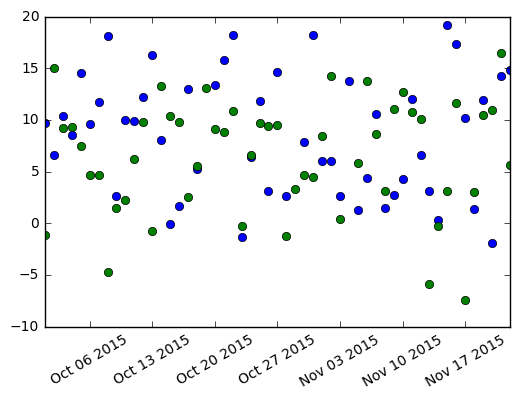

In [658]:
x_1 = data[data['plan'] == 'ad_group_16']['data_date']
x_2 = data[data['plan'] == 'ad_group_14']['data_date']
y_1 = data[data['plan'] == 'ad_group_16']['cpa']
y_2 = data[data['plan'] == 'ad_group_14']['cpa']
plt.plot_date(x_1, y_1)
plt.plot_date(x_2, y_2)
plt.xticks(rotation = 30)
plt.show()

# The Prediction of Exposured

In [18]:
test=  data[data['plan'] == 'ad_group_14'][['data_date', 'exposured']]

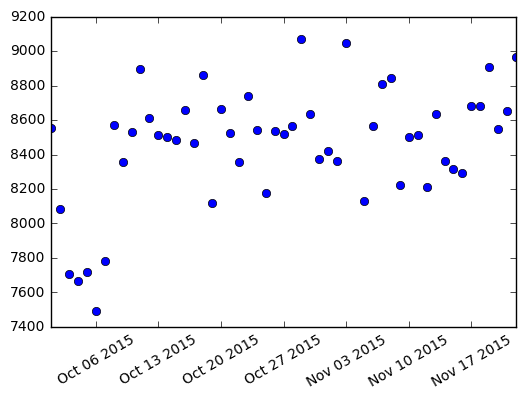

In [653]:
x = test['data_date']
y = test['exposured']
plt.plot_date(x, y)
plt.xticks(rotation = 30)
plt.show()

In [1503]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.cross_validation import KFold

In [1518]:
pred = data[data['plan'] == 'ad_group_14'].ix[:,[0, 1, 2, 3, 4, 7, 8, 10] ]


In [1505]:
X_train, X_test, y_train, y_test = train_test_split(pred.ix[:, 0:10], pred['cpa'], test_size = 0.33, random_state = 42)


In [1506]:
def mean_squared_error_(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5
RMSE = make_scorer(mean_squared_error_, greater_is_better = False)

In [1507]:
def model_random_forest(Xtrain, Xtest, ytrain):
    X_train = Xtrain
    y_trian = ytrain
    rfr = RandomForestRegressor(n_jobs = 1, random_state = 0)
    param_grid = {}
    model = GridSearchCV(estimator = rfr, param_grid = param_grid, n_jobs = 1, cv = 10, scoring = RMSE)
    model.fit(X_train, y_train)
    print('Radom forest regression ...')
    print('Best Params:')
    print(model.best_params_)
    print('Best CV score:')
    print(-model.best_score_)
    
    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

In [1508]:
model_random_forest(X_train, X_test, y_train)

Radom forest regression ...
Best Params:
{}
Best CV score:
1.51590152776


(array([  9.00132011,  10.45248365,   3.01669336,   0.14469682,
          0.31029692,   3.6853925 ,   5.66466056,  13.85300909,
          9.27429965,  14.0701    ,  13.5347601 ,   0.6445384 ,
          9.35208234,   3.73992424,   6.32201984,   8.14220644,
          2.57503175,   9.87612061]), 1.5159015277620012)

In [1509]:
def model_gradient_boosting_tree(Xtrain, Xtest, ytrain):
    X_trian = Xtrain
    y_train = ytrain
    gbr = GradientBoostingRegressor(random_state = 0)
    param_grid = {}
    model = GridSearchCV(estimator = gbr, param_grid = param_grid, n_jobs = 1, cv = 10, scoring = RMSE)
    model.fit(X_train, y_train)
    print('Gradient boosted tree regression ...')
    print('Best Params:')
    print(model.best_params_)
    print('Best CV Score: ')
    print(-model.best_score_)
    
    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

        

In [1510]:
def model_xgb_regression(Xtrain, Xtest, ytrain):
    X_train = Xtrain
    y_train = ytrain
    xgbreg = xgb.XGBRegressor(seed = 0)
    param_grid = {}
    model = GridSearchCV(estimator = xgbreg, param_grid = param_grid, n_jobs = 1, cv = 10, scoring = RMSE)
    model.fit(X_train, y_train)
    print('eXtreme Gradient Boosting regression ...')
    print('Best Params: ')
    print(model.best_params_)
    print('Best CV Score: ')
    print(-model.best_score_)
    
    y_pred = model.predict(Xtest)
    return y_pred, -model.best_score_

In [1511]:
model_xgb_regression(X_train, X_test, y_train)

eXtreme Gradient Boosting regression ...
Best Params: 
{}
Best CV Score: 
0.929858720637


(array([  9.20012951,  10.37025547,   3.04228973,  -0.06400079,
         -0.79190564,   4.71803379,   5.6833539 ,  14.23883438,
          9.46446896,  13.8143425 ,  13.13502312,   1.24751711,
          9.46446896,   4.71803379,   5.6833539 ,   6.66229582,
          2.91618991,   9.78903389], dtype=float32), 0.9298587206369382)

In [1512]:
def model_extra_trees_regression(Xtrain, Xtest, ytrain):
    X_train = Xtrain
    y_train = ytrain
    etr = ExtraTreesRegressor(n_jobs=1, random_state=0)
    param_grid = {}
    model = GridSearchCV(estimator = etr, param_grid = param_grid, n_jobs = 1, cv = 10, scoring = RMSE)
    model.fit(X_train, y_train)
    
    print('Extra trees regression ...')
    print('Best Params: ')
    print(model.best_params_)
    print('Best CV Score: ')
    print(-model.best_score_)

In [1513]:
model_extra_trees_regression(X_train, X_test, y_train)

Extra trees regression ...
Best Params: 
{}
Best CV Score: 
0.820679768474


# Emsemble

In [1514]:
class ensemble(object):
    def __init__(self, n_folds, stacker, base_models):
        self.n_folds = n_folds
        self.n_stacker = stacker
        self.base_models = base_models
        
    def fit_predict(self, train, test, ytr):
        X = train.values
        y = ytr.values
        T = test.values
        
        folds = list(KFold(len(y), n_folds = self.n_folds, shuffle = True, random_state = 0))
        
        S_train = np.zeros((x.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))

        for i, reg in enumerate(base_models):
            print ('Fitting the base model ...')
            S_test_i = np.zeros((T.shape[0], len(folds)))

            for j, (train_idx, test_idx) in enumerate(folds):

                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]
                y_holdout = y[test_idx]
                reg.fit(X_train, y_train)
                y_pred = reg.predict(X_holdout)[:]
                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = reg.predict(T)[:]
            S_test[:, i] = S_test_i.mean(1)
        

        print ('Stacking base models ...')
        param_grid = {
            'alpha': [1e-3,5e-3,1e-2,5e-2,1e-1,0.2,0.3,0.4,0.5,0.8,1e0,3,5,7,1e1],
        }
        grid = GridSearchCV(estimator = self.n_stacker, param_grid = param_grid, n_jobs = 1, cv = 5, scoring = RMSE)
        grid.fit(S_train, y)

        try:
            print('Param grid:')
            print(param_grid)
            print('Best Params:')
            print(grid.best_params_)
            print('Best CV estimator:')
            print(-grid.best_score_)
            print('Best estimator: ')
            print(grid.best_estimator_)
        except:
            pass
        
        y_pred = grid.predict(S_test)[:]
        return y_pred, -grid.best_score_

In [1515]:
base_models = [
    RandomForestRegressor(
        n_jobs = 1, random_state = 0,
        n_estimators = 500, max_features = 4
    ),
    
    RandomForestRegressor(
        n_jobs = 1, random_state = 0,
        n_estimators = 500, max_features = 6,
        max_depth = 7
    
    ),
    
    
    ExtraTreesRegressor(
        n_jobs = 1, random_state = 0,
        n_estimators = 500, max_features = 4
    ),
    
    ExtraTreesRegressor(
        n_jobs = 1, random_state = 0,
        n_estimators = 500, max_features = 6
    ),
    
    GradientBoostingRegressor(
        random_state = 0,
        n_estimators = 500, max_features = 4, max_depth = 6,
        learning_rate = 0.05, subsample = 0.08
    ),
    
    GradientBoostingRegressor(
        random_state = 0,
        n_estimators = 500, max_features = 6, max_depth = 6,
        learning_rate = 0.05, subsample = 0.08
    ),
    
    
    xgb.XGBRegressor(
        seed = 0,
        n_estimators = 500, max_depth = 10,
        learning_rate = 0.05, subsample = 0.8, colsample_bytree = 0.75
    ),
    
    
    xgb.XGBRegressor(
        seed = 0,
        n_estimators = 500, max_depth = 7,
        learning_rate = 0.05, subsample = 0.8, colsample_bytree = 0.75
    ),
    
    LassoCV(alphas = [1, 0.1, 0.001, 0.005]),
    KNeighborsRegressor(n_neighbors = 5),
    KNeighborsRegressor(n_neighbors = 10),
    KNeighborsRegressor(n_neighbors = 15),
    KNeighborsRegressor(n_neighbors = 25),
    LassoLarsCV(),
    ElasticNet(),
    SVR()
    
]


In [1516]:
ensem = ensemble(
        n_folds = 2,
        stacker = Ridge(),
        base_models = base_models)

In [1517]:
y_pred, score = ensem.fit_predict(pred.ix[:,[0, 1, 2, 3, 4, 5, 6, 7]], X_test, pred.cpa)


Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Fitting the base model ...
Stacking base models ...
Param grid:
{'alpha': [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1.0, 3, 5, 7, 10.0]}
Best Params:
{'alpha': 0.001}
Best CV estimator:
0.00068601670175
Best estimator: 
Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


# Cluster Groups into Good, Average and Bad

In [180]:
# class KMeans():
#     def __init__(self, file, k):
#         self.data, self.restrictions = self.parse_vectors(filename)
#         self.k = k
#         self.centroids = self.initial_centroids(self.data, self.k)
#         self.clusters = list()
        
#     def parse_vectors(self, filename):
#         reader = csv.reader(open(filename, 'r'), delimiter = ',')
#         vectors = []
#         restrictions = []
        
#         for row_ct, row in enumerate(reader):
#             if row_cnt > 0:
#                 new_row = dict()
#                 new_row['cluster'] = 0
#                 if int(restrictions[0]) == 0:
#                     new_row['key'] = row[0]
#                 new_row['val'] = tuple([x for i, x in enumerate(row) 
#                                         if i < len(restriction[i] 
#                                                    and int(restrictions[i] == 1 
#                                                    and len(x.trip()) >= 1))])
#                 vectors.append(new_row)
#             else:
#                 restrictions.extend(row)
                
#         return vectors, restrictions
    
#     def initial_centroids(self, data, k):
#         row_len = len(data[0]['val'])
#         c = [0 for i in range(row_len)]
        
#         for point in data:
#             for ndx, val in enumerate(c):
#                 c[ndx] += float(point['val'][ndx])
                
#         for i in range(row_len):
#             c[i] = c[i] / len(data)
            
#         centroids = []
        
#         for m in range(int(k)):
#             maxdist = 0
#             maxndx = 0
#             for ndx, point in enumerate(data):
#                 if len(centroids) > 0:
#                     if not any(d.get['val'] == point['val'] for d in centroids):
#                         dist = self.distance(point['val'], centroids[m-1]['val'])
#                     else:
#                         dist = self.distance(point['val'], c)
                        
#                     if maxdist < dist:
#                         maxdist = dist
#                         maxndx = ndx
                        
#             cluster = dict()
#             cluster['cluster'] = m
#             cluster['val'] = data[maxndx]['val']
#             centroids.append(cluster)
            
#         return centroids
    
#     def cluster(self):
#         change = True
        
#         while change:
#             change = False
            
#             for i, point in enumerate(self.data):
#                 closest_cluster != point['cluster']:
#                     change = True
#                     self.data[i]['cluster'] = closest_cluster
                    
#             if change:
#                 self.recalc_centroids()
                
#         for centroid in self.centroids:
#             if 'key' in self.data[0]:
#                 cluster_points = ([(x['key'], x['val']) for x in self.data if x['cluster']])
#             self.clusters.append(cluster_points)
            
#         return self.clusters
    
#     def recalc_centroids(self):
#         row_len = len(self.data[0]['val'])
#         c = [[o for i in range(row_len)] for j in range(self.k)]
#         for point in self.data:
#             cluster_ndx = point['cluster']
#             for ndx, val in enumerate(c[cluster_ndx]):
#                 c[cluster_ndx][ndx] += float(point['val'][ndx])
                
            
#         for cluster_ndx, x in enumerate(c):
#             cluster_count = len([d for d in self.data if d['cluster'] == cluster_ndx])
#             if cluster_count != 0:
#                 for i in range(row_len):
#                     c[cluster_ndx][i] = c[cluster_ndx][i] / cluster_count
                    
#             if i, centroid in enumerate(c):
#                 self.centroids[i]['val'] = c[i]
                
#         for i, centroid in enumerate(self.centroids):
#             self.centroids[i]['val'] = c[i]
            
#     def distance(self, v1, v2):
#         if len(v1) != len(v2):
#             print "Error"
#             return
#         else:
#             total = 0
#             for i in range(len(v1)):
#                 val = float(v1[i]) - float(v2[i])
#                 val = val * val
#                 total += val
#             return math.sqrt(total)
        
#     def closest(self, point):
#         minDist = sys.maxint
#         minCluster = -1
#         for ndx, cluster = enumerate(self.centroids):
#             dist = self.distance(cluster['val'], point['val'])
#             if minDist > dist:
#                 minDist = dist
#                 minCluster = cluster['cluster']
                
#         return minCluster
    
    
#     def main():
#         filename = 0
#         threshold = 0
                    
#         if len(sys.argv) > 3 or len(sys.argv) < 2:
#             print "Usage: python kmeans.py <filename> num_clusters"
#             return
        
#         if len(sys.argv) == 3:
#             numClusters = int(sys.argv[2])
            
#         kmeans = KMeans(sys.argv[1], numClusters)
#         clusters = kmeans.cluster()
        
#         for i, cluster in enumerate(clusters):
#             print "Cluster " + str(i+1)+ ":" 
#             centroid = kmeans.centroids[i]['val']
#             print "Center: ", len(cluster)
#             print "Points: "
#             maxdist = 0
#             mindist = sys
        
                              

### test kmeans code...

In [209]:
test = data[['ctr', 'cvr', 'cpa']].dropna()

In [215]:
test = test.head(100)

In [290]:
kmeans = KMeans(n_clusters = 3, random_state = 0)

In [291]:
# kmeans.fit_transform(test)

In [292]:
kmeans.fit(test)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [293]:
kmeans.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 3,
 'n_init': 10,
 'n_jobs': 1,
 'precompute_distances': 'auto',
 'random_state': 0,
 'tol': 0.0001,
 'verbose': 0}

In [294]:
kmeans.score(test)

-4344.0581845058496

In [295]:
test['groups'] = kmeans.labels_

In [296]:
kmeans.inertia_

4344.0581845058441

## Test plotting code...

### Get the best number of groups

In [297]:
estimators = [('k_means_4', KMeans(n_clusters = 4)),
              ('k_means_3', KMeans(n_clusters = 3)),
              ('k_means_2', KMeans(n_clusters = 2))]


In [298]:
fignum = 1
titles = ['4_clusters', '3_clusters', '2_clusters']

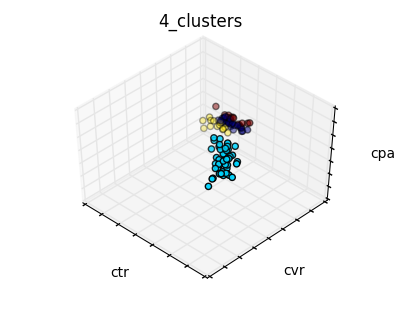

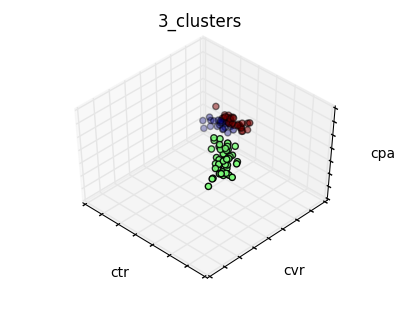

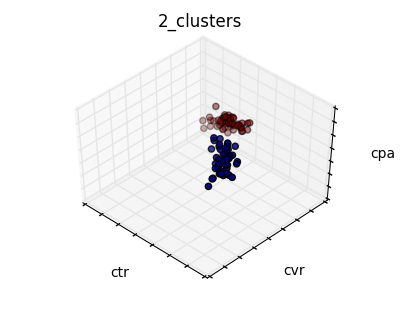

In [299]:
for name, est in estimators:
    fig = plt.figure(fignum, figsize = (4, 3))
    ax = Axes3D(fig, rect = [0, 0, 0.95, 1], elev = 48, azim = 134)
    est.fit(test)
    labels = est.labels_
    ax.scatter(test.iloc[:, 0].as_matrix(), test.iloc[:, 1].as_matrix(), test.iloc[:, 2].as_matrix(),
              c = labels.astype(np.float), edgecolor = 'k')
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('ctr')
    ax.set_ylabel('cvr')
    ax.set_zlabel('cpa')
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1
    


fig.show()
plt.show()

In [300]:
est.inertia_

9850.3746289419232